## Import the dependencies

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

## Import data into TF dataset object

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names=dataset.class_names

In [6]:
len(dataset)

68

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


## Visualize some images

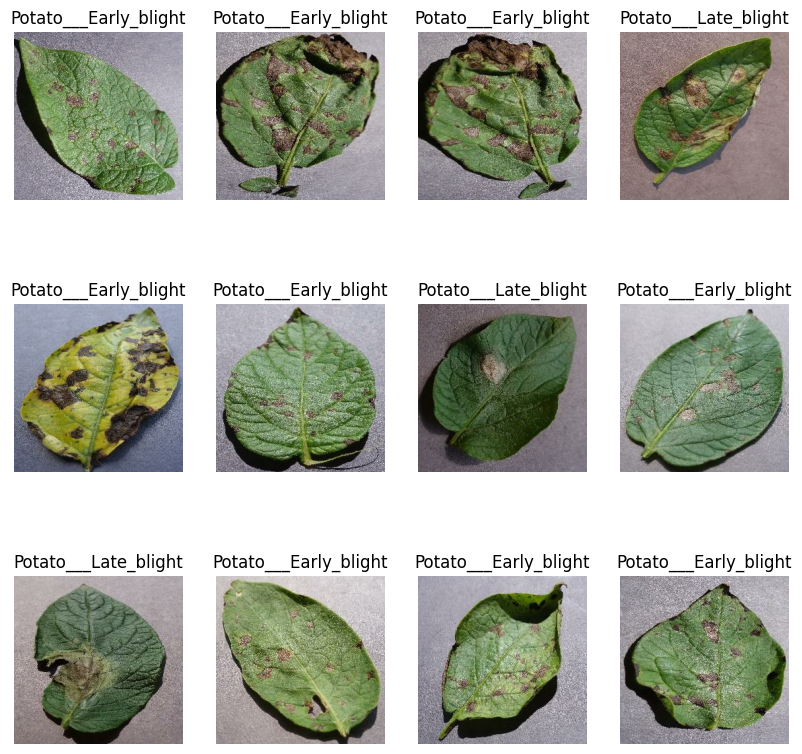

In [8]:
plt.figure(figsize=(10, 10))
for image_batch,labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(dataset.class_names[labels_batch[i]])
        plt.axis("off")

## Splitting the dataset
We will be splitting the dataset as 80% training and 10% validation and 10% test dataset

In [9]:
len(dataset)

68

In [10]:
# as we dont have train_test_split function in tensorflow, we will be using the dataset.take() method
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds=dataset.take(54)
len(train_ds)

54

In [12]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [13]:
# of this test_ds, we will take 10% as validation
val_ds=test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [15]:
#we hardcoded the splitting, but we can write a function to do this
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=123)
    train_size=int(train_split * ds_size)
    val_size=int(val_split * ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [16]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

## Cache,Shuffle,Prefetch the Dataset

In [18]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Build the Model

# Resize and Normalize the dataset

Currently image pixel value is in the range 0-255, normalize it from 0-1 by diving by 256. Add this as a layer in Sequential Model


In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])


Add a data augmentation layer as it boosts the accurace when we have less data

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
# apply data augmnentation to train dataset
train_ds=train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture
We use a CNN coupled with Softmax activation in output layer, also adding a resizing and rescaling layer, normalizing and data augmentation layer


In [22]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(), 
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [24]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
54/54 [==============================] - 8s 104ms/step - loss: 0.8800 - accuracy: 0.5123 - val_loss: 0.7941 - val_accuracy: 0.5833
Epoch 2/50
54/54 [==============================] - 5s 90ms/step - loss: 0.6160 - accuracy: 0.7277 - val_loss: 0.6639 - val_accuracy: 0.6615
Epoch 3/50
54/54 [==============================] - 5s 94ms/step - loss: 0.4511 - accuracy: 0.8087 - val_loss: 0.4057 - val_accuracy: 0.8177
Epoch 4/50
54/54 [==============================] - 5s 94ms/step - loss: 0.3577 - accuracy: 0.8527 - val_loss: 0.4928 - val_accuracy: 0.7865
Epoch 5/50
54/54 [==============================] - 5s 94ms/step - loss: 0.3747 - accuracy: 0.8492 - val_loss: 0.3281 - val_accuracy: 0.8542
Epoch 6/50
54/54 [==============================] - 5s 93ms/step - loss: 0.2480 - accuracy: 0.9055 - val_loss: 0.2788 - val_accuracy: 0.8906
Epoch 7/50
54/54 [==============================] - 5s 93ms/step - loss: 0.2292 - accuracy: 0.9137 - val_loss: 0.2885 - val_accuracy: 0.8854
Epoch 8/50
5

In [26]:
scores=model.evaluate(test_ds)


8/8 [==============================] - 1s 14ms/step - loss: 0.1707 - accuracy: 0.9336


In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
len(history.history['loss'])

50

## Plot Accuracy and Loss Curves

In [30]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']   

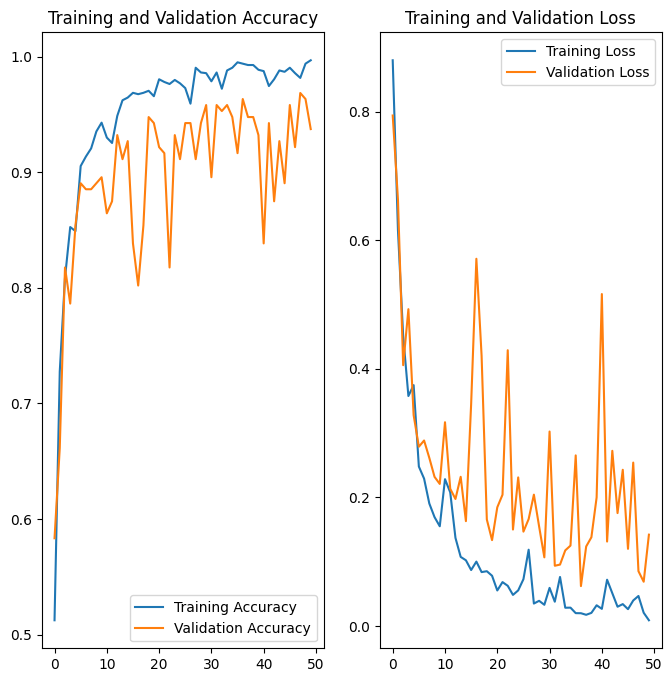

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')  
plt.title('Training and Validation Loss')
plt.show()

First image to predict:
Actual label: Potato___Early_blight
1/1 [==============================] - 0s 82ms/step
predicted label: Potato___Early_blight


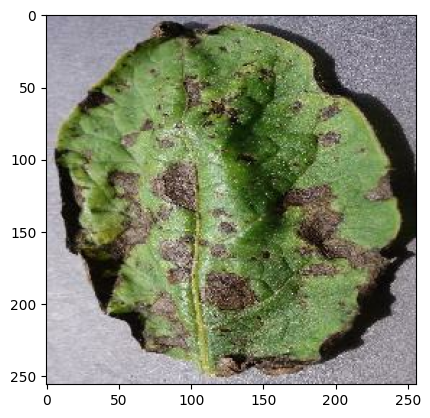

In [32]:
import numpy as np
for image_batch,labels_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype("uint8")
    first_label=labels_batch[0].numpy()

    print("First image to predict:")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])

    batch_prediction=model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Inference function

In [33]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array, 0)  # Create a batch

    predictions=model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence=round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 12ms/step


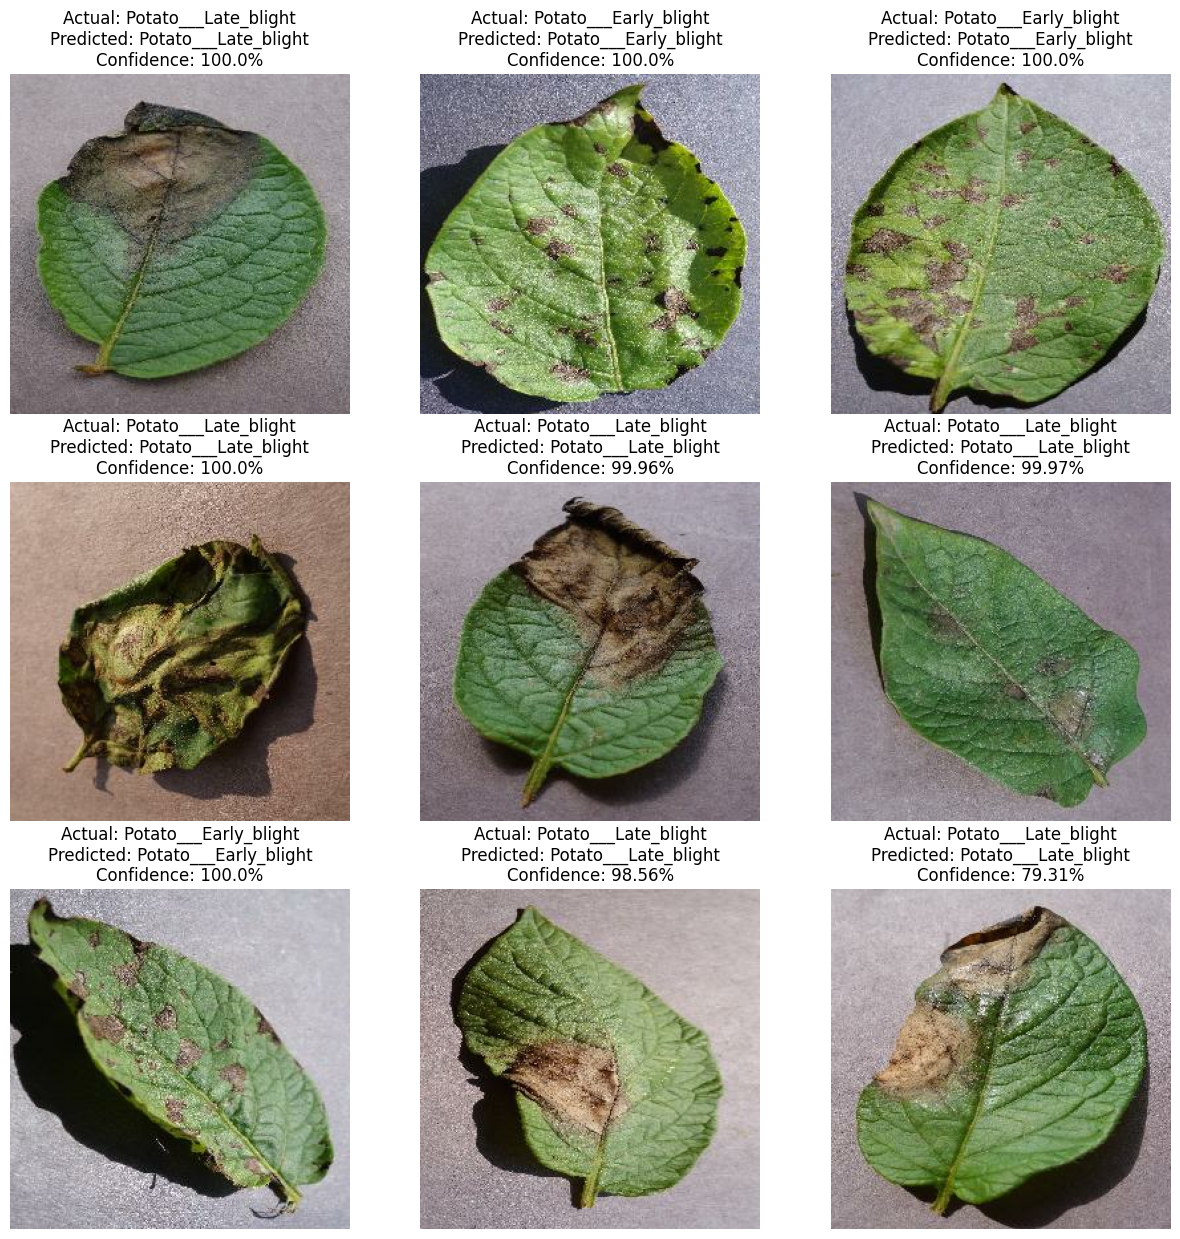

In [34]:
plt.figure(figsize=(15, 15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

In [35]:
import os 
model_version=max([int(i) for i in os.listdir("../models")+[0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
